# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Connect to Github repository and import code

In [3]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!git clone --branch 8-bit-Categorical --single-branch https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 196, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 196 (delta 4), reused 13 (delta 3), pack-reused 179 (from 1)
Receiving objects: 100% (196/196), 180.30 MiB | 16.21 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Updating files: 100% (9/9), done.


In [14]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin 8-bit-Categorical

# refrsh the imports
from importlib import reload
import VQ.model
reload(VQ.model)

from VQ.model import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS

/content/VQ-VAE-Tranformer-Image-Gen
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 384 bytes | 384.00 KiB/s, done.
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            8-bit-Categorical -> FETCH_HEAD
   d8d1b6b..33a47a6  8-bit-Categorical -> origin/8-bit-Categorical
Updating d8d1b6b..33a47a6
Fast-forward
 VQ/model.py | 3 ++-
 1 file changed, 2 insertions(+), 1 deletion(-)


### Load CelebA dataset

Dataset URL: https://www.kaggle.com/datasets/zuozhaorui/celeba
License(s): unknown
100% 2.64G/2.64G [00:01<00:00, 1.17GB/s]
100% 2.64G/2.64G [00:01<00:00, 1.53GB/s]


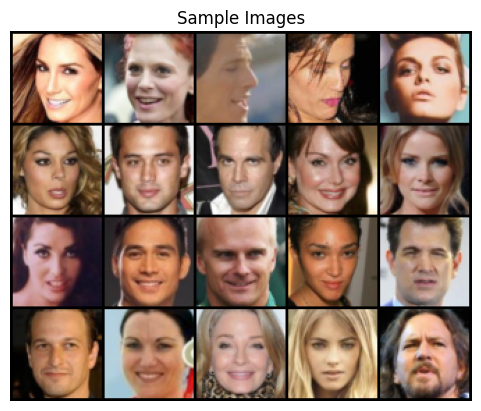

In [6]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

# load dataset using ImageFolder dataset
class CelebATransform:
    '''
    Crops around the face and resizes to IMG_HxIMG_W
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        return img

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.base = torchvision.datasets.ImageFolder(root=root, transform=CelebATransform())

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base.__getitem__(idx)
        target = torch.from_numpy(np.array(img)).permute(2, 0, 1).long()
        input = target.float() / 255.0
        return input, target

celeba = CelebADataset(root='./data/celeba')

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x)
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Train model

Checkpoint loaded. Resuming from training step 3000.
04:08:13 Begin Training
04:08:42 TRAINING Step [3100/20413]; Loss: 4.8868; Commitment: 0.7594; Usage (min/med/max/dead): 0.00, 0.72, 7.99, 39%
04:09:11 TRAINING Step [3200/20413]; Loss: 4.8940; Commitment: 0.7723; Usage (min/med/max/dead): 0.00, 0.78, 7.46, 38%
04:09:40 TRAINING Step [3300/20413]; Loss: 4.8941; Commitment: 0.7768; Usage (min/med/max/dead): 0.00, 0.81, 6.91, 38%
04:10:09 TRAINING Step [3400/20413]; Loss: 4.8979; Commitment: 0.7793; Usage (min/med/max/dead): 0.00, 0.83, 6.22, 37%
04:10:38 TRAINING Step [3500/20413]; Loss: 4.8977; Commitment: 0.7871; Usage (min/med/max/dead): 0.00, 0.85, 5.63, 36%
04:11:07 TRAINING Step [3600/20413]; Loss: 4.8989; Commitment: 0.7959; Usage (min/med/max/dead): 0.00, 0.87, 5.49, 35%
04:11:36 TRAINING Step [3700/20413]; Loss: 4.9056; Commitment: 0.8037; Usage (min/med/max/dead): 0.00, 0.89, 4.94, 35%
04:12:05 TRAINING Step [3800/20413]; Loss: 4.9160; Commitment: 0.8186; Usage (min/med/max/

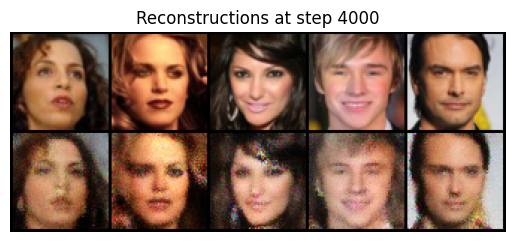

04:13:33 TRAINING Step [4100/20413]; Loss: 4.9464; Commitment: 0.8525; Usage (min/med/max/dead): 0.00, 1.00, 4.42, 34%
04:14:02 TRAINING Step [4200/20413]; Loss: 4.9450; Commitment: 0.8594; Usage (min/med/max/dead): 0.00, 1.01, 4.36, 33%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6858125da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6858125da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

04:14:31 TRAINING Step [4300/20413]; Loss: 4.9558; Commitment: 0.8728; Usage (min/med/max/dead): 0.00, 1.02, 4.36, 33%
04:15:00 TRAINING Step [4400/20413]; Loss: 4.9605; Commitment: 0.8796; Usage (min/med/max/dead): 0.00, 1.03, 4.25, 33%
04:15:29 TRAINING Step [4500/20413]; Loss: 4.9683; Commitment: 0.8904; Usage (min/med/max/dead): 0.00, 1.04, 4.17, 33%
Checkpoint saved at step 4583 to /content/drive/MyDrive/vq_models/checkpoint.pt


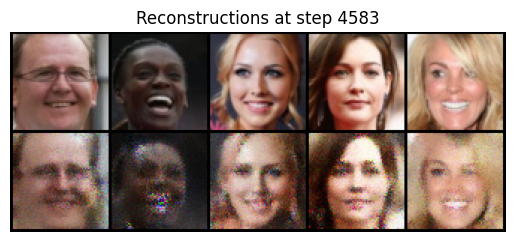

04:16:00 TRAINING Step [4600/20413]; Loss: 4.9710; Commitment: 0.8965; Usage (min/med/max/dead): 0.00, 1.04, 4.03, 32%
04:16:29 TRAINING Step [4700/20413]; Loss: 4.9782; Commitment: 0.9014; Usage (min/med/max/dead): 0.00, 1.05, 3.95, 32%
04:16:58 TRAINING Step [4800/20413]; Loss: 4.9833; Commitment: 0.9084; Usage (min/med/max/dead): 0.00, 1.05, 3.86, 32%
04:17:27 TRAINING Step [4900/20413]; Loss: 4.9916; Commitment: 0.9224; Usage (min/med/max/dead): 0.00, 1.06, 3.81, 32%
04:17:56 TRAINING Step [5000/20413]; Loss: 4.9992; Commitment: 0.9235; Usage (min/med/max/dead): 0.00, 1.07, 3.70, 32%
Checkpoint saved at step 5000 to /content/drive/MyDrive/vq_models/checkpoint.pt


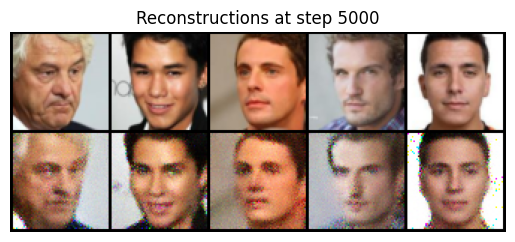

04:18:26 TRAINING Step [5100/20413]; Loss: 5.0013; Commitment: 0.9308; Usage (min/med/max/dead): 0.00, 1.08, 3.75, 31%
04:18:55 TRAINING Step [5200/20413]; Loss: 5.0017; Commitment: 0.9354; Usage (min/med/max/dead): 0.00, 1.09, 3.70, 31%
04:19:25 TRAINING Step [5300/20413]; Loss: 5.0055; Commitment: 0.9420; Usage (min/med/max/dead): 0.00, 1.09, 3.59, 31%
04:19:54 TRAINING Step [5400/20413]; Loss: 5.0104; Commitment: 0.9487; Usage (min/med/max/dead): 0.00, 1.09, 3.63, 31%
04:20:23 TRAINING Step [5500/20413]; Loss: 5.0091; Commitment: 0.9473; Usage (min/med/max/dead): 0.00, 1.10, 3.57, 31%
04:20:52 TRAINING Step [5600/20413]; Loss: 5.0146; Commitment: 0.9527; Usage (min/med/max/dead): 0.00, 1.11, 3.55, 31%
04:21:21 TRAINING Step [5700/20413]; Loss: 5.0181; Commitment: 0.9606; Usage (min/med/max/dead): 0.00, 1.11, 3.49, 31%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6858125da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b6858125da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

04:21:50 TRAINING Step [5800/20413]; Loss: 5.0217; Commitment: 0.9607; Usage (min/med/max/dead): 0.00, 1.12, 3.44, 31%
04:22:19 TRAINING Step [5900/20413]; Loss: 5.0207; Commitment: 0.9667; Usage (min/med/max/dead): 0.00, 1.12, 3.41, 31%
04:22:48 TRAINING Step [6000/20413]; Loss: 5.0316; Commitment: 0.9737; Usage (min/med/max/dead): 0.00, 1.13, 3.45, 31%
Checkpoint saved at step 6000 to /content/drive/MyDrive/vq_models/checkpoint.pt


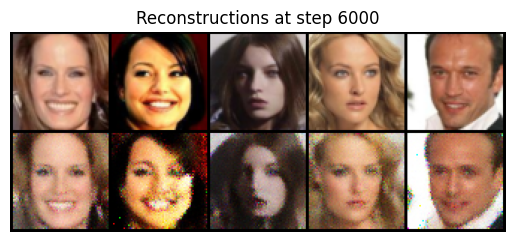

KeyboardInterrupt: 

In [20]:
from time import strftime

# Initialize and train a model. If you just want to load one from a checkpoint and not train, set EPOCHS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training hyperparemeters
EPOCHS = 11
BATCH_SIZE = 256
BETA = 0.25
TEMP_ANNEAL_RANGE = (2.0, 1.0)
TEMP_ANNEAL_STEPS = 20000
GRAD_CLIP = 1.0

# logging/saving hyperparemters
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
CHECKPOINT_DIR = '/content/drive/MyDrive/vq_models'
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'checkpoint.pt')
LOAD_FROM_CHECKPOINT = True

dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(use_EMA=True, batch_size=BATCH_SIZE)
model = VQ_VAE(encoder, decoder, quantizer, use_EMA=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

training_losses = []
training_steps = 0
running_losses = [0.0, 0.0, 0.0]

# load from checkpoint
if LOAD_FROM_CHECKPOINT:
    if not os.path.exists(CHECKPOINT_PATH):
        print(f'WARNING: Checkpoint not found at {CHECKPOINT_PATH}!')
    else:
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint['model_state'])
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        training_steps = checkpoint['training_steps']
        training_losses = checkpoint['training_losses']
        running_losses = checkpoint['running_losses']

        print(f'Checkpoint loaded. Resuming from training step {training_steps}.')

total_steps = training_steps + len(dataloader) * EPOCHS

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
model.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        input, target = batch
        input = input.to(device)
        target = target.to(device)

        t_max, t_min = TEMP_ANNEAL_RANGE
        temp = min(t_min, t_max + (t_min - t_max) * (training_steps / TEMP_ANNEAL_STEPS))

        reconstruction_loss, commitment_loss, codebook_loss = model(input, target, temp=temp)
        if model.use_EMA:
            loss = reconstruction_loss + BETA * commitment_loss + codebook_loss
        else:
            loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        if GRAD_CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRAD_CLIP)
        optimizer.step()
        training_steps += 1

        running_losses[0] += loss.item()
        running_losses[1] += reconstruction_loss.item()
        running_losses[2] += commitment_loss.item()

        # logging step
        if training_steps % LOG_INTERVAL == 0:
            avg_losses = [loss / LOG_INTERVAL for loss in running_losses]
            running_losses = [0.0, 0.0, 0.0]
            training_losses.append((training_steps, avg_losses))
            with torch.no_grad():
                p = model.quantizer.N / model.quantizer.N.sum() * 512
                print(f'{strftime('%H:%M:%S')} TRAINING Step [{training_steps}/{total_steps}]; Loss: {avg_losses[0]:.4f}; Commitment: {avg_losses[2]:.4f}; Usage (min/med/max/dead): {p.min().item():.2f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.01) / 512 * 100:.0f}%')

        # saving step
        if training_steps % SAVE_INTERVAL == 0 or batch_idx == len(dataloader) - 1:
            checkpoint = {
                'training_steps': training_steps,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'training_losses': training_losses,
                'running_losses': running_losses,
            }

            torch.save(checkpoint, CHECKPOINT_PATH)
            print(f'Checkpoint saved at step {training_steps} to {CHECKPOINT_PATH}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2

            input, target = next(iter(dataloader))
            input = input[:grid_x * grid_y // 2].to(device)
            target = target[:grid_x * grid_y // 2].to(device)

            model.eval()
            logits = model.reconstruct(input)
            reconstructed = model.decoder.sample_from_logits(logits)
            model.train()

            images = torch.cat((target, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

            plt.title(f'Reconstructions at step {training_steps}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            plt.show()

print(f'Training complete.')

# Prepare loss data
steps_list = [item[0] for item in training_losses]
avg_losses_list = [item[1] for item in training_losses]

steps = np.array(steps_list)
losses = np.array(avg_losses_list)   # shape: (num_steps, 3)

# Prepare reconstructions
grid_x = 5
grid_y = 4

input, target = next(iter(dataloader))
input = input[:grid_x * grid_y // 2].to(device)
target = target[:grid_x * grid_y // 2].to(device)

model.eval()
logits = model.reconstruct(input)
reconstructed = model.decoder.sample_from_logits(logits)
model.train()

images = torch.cat((target, reconstructed), dim=0)
img = torchvision.utils.make_grid(images.float() / 255.0, grid_x)

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(steps, losses[:, 0], label='Loss')
axes[0].plot(steps, losses[:, 1], label='Reconstruction Loss')
axes[0].plot(steps, losses[:, 2], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [ ]:
from tqdm import tqdm

celeba_indices = []

model.eval()
for batch in tqdm(dataloader):
    input, target = batch
    input = input.to(device)
    indices = model.compute_indices(input)
    celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
print('Shape:', celeba_indices.shape)
celeba_indices = celeba_indices.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, os.path.join(CHECKPOINT_DIR, "celeba_vq_indices_uint16.pt"))

100%|██████████| 1583/1583 [01:33<00:00, 16.96it/s]


Concatenating...
Shape: torch.Size([405198, 64])
Saving...


### Random Image Generation with Uniform Prior

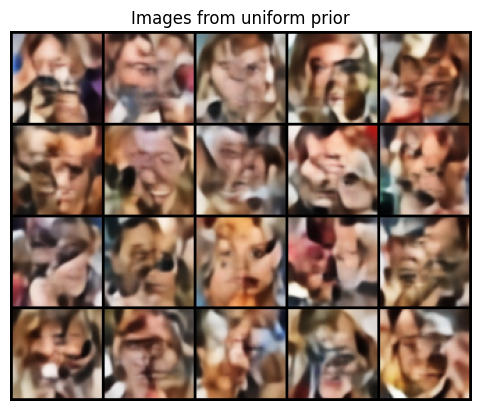

In [ ]:
# visualize
grid_x = 5
grid_y = 4

model.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    embeddings = model.quantizer.get_latent_tensor_from_indices(samples)
    logits = model.decoder(embeddings)
    reconstructed = model.decoder.sample_from_logits(logits)

img = torchvision.utils.make_grid(reconstructed.float() / 255.0, grid_x)
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())